In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import random
from sklearn.metrics import accuracy_score

import requests, zipfile, io
import os, glob
import shutil

print(tf.__version__)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

2.9.1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
print(info)
print(imdb)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset.
    This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='~\\tensorflow_datasets\\imdb_reviews\\plain_text\\1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=1>,
     

In [3]:
# dir (imdb)
imdb.keys()

dict_keys(['train', 'test', 'unsupervised'])

In [4]:
for example in imdb['train'].take(2):
    print(example[0], '\n')

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string) 

tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because

In [5]:
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)
print(len(training_labels_final), len(testing_labels_final))

25000 25000


In [6]:
vocab_size = 10000
max_length = 120
embedding_dim = 16
trunc_type='post'
oov_tok = "<OOV>"
SHUFFLE_SIZE=len(training_labels_final) // 2
BATCH_SIZE = 32
EPOCHS = 50 
PATIENCE = 5
MONITOR = 'val_acc'

In [7]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(testing_sequences,maxlen=max_length, truncating=trunc_type)


xtrain = tf.data.Dataset.from_tensor_slices(padded)
ytrain = tf.data.Dataset.from_tensor_slices(training_labels_final)
print(xtrain, ytrain)

train_dataset = tf.data.Dataset.zip((xtrain, ytrain)).shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(train_dataset, '\n\n')

xtest = tf.data.Dataset.from_tensor_slices(testing_padded)
ytest = tf.data.Dataset.from_tensor_slices(testing_labels_final)
print(xtest, ytest)

test_dataset = tf.data.Dataset.zip((xtest, ytest)).shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
print(test_dataset, '\n\n')

<TensorSliceDataset element_spec=TensorSpec(shape=(120,), dtype=tf.int32, name=None)> <TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> 


<TensorSliceDataset element_spec=TensorSpec(shape=(120,), dtype=tf.int32, name=None)> <TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 120), dtype=tf.int32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))> 




In [8]:
MODEL_NAME = './models/imdb_review_embidding_flattened_full_verse.h5'

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Nadam(1e-3),
    metrics=['acc']
)

# Print the model summary
print(model.summary())

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-5)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE*2, restore_best_weights=True)]

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
782/782 [==============================] - 8s 9ms/step - loss: 0.4987 - acc: 0.7408 - val_loss: 0.3818 - val_acc: 0.8267 - lr: 0.0010
Epoch 2/50
782/782 [============

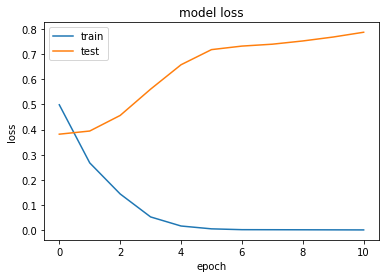

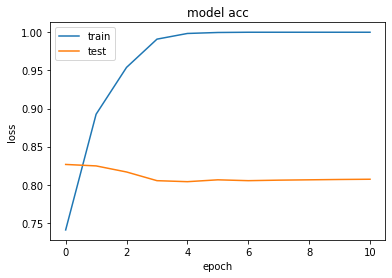

In [9]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
MODEL_NAME = './models/imdb_review_embidding_global_pooling_full_verse.h5'

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=tf.keras.optimizers.Nadam(1e-3),
    metrics=['acc']
)

# Print the model summary
print(model.summary())

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor=MONITOR, factor=0.1, patience=PATIENCE, min_lr=1e-5)]
callbacks += [tf.keras.callbacks.ModelCheckpoint(MODEL_NAME, monitor=MONITOR, save_best_only=True)]
callbacks += [tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=PATIENCE*2, restore_best_weights=True)]

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=test_dataset,
    callbacks=callbacks
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 6)                 102       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
782/782 [==============================] - 9s 10ms/step - loss: 0.5628 - acc: 0.7373 - val_loss: 0

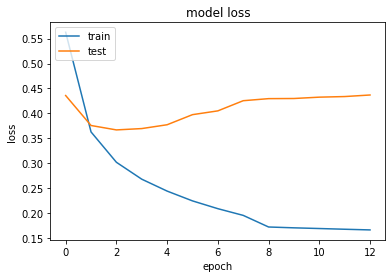

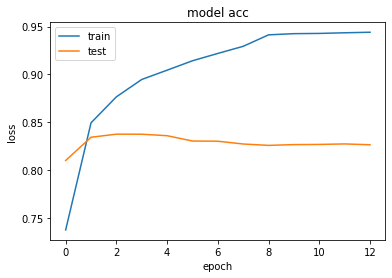

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()